[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EleonoraAiello/AIM23-24/blob/main/DecisionTrees.ipynb)

In [2]:
from sklearn import preprocessing, decomposition, model_selection
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#import graphviz
#from graphviz import Source
#from IPython.display import SVG
import pandas as pd
import numpy as np
import scipy
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from matplotlib.colors import ListedColormap
import seaborn as sns


In [ ]:
!wget https://raw.githubusercontent.com/EleonoraAiello/AIM23-24/main/dataT1DEXIstudyVideo_sedentary.csv

In [3]:
%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'figure.figsize' : [12,8],
                     })

# CSV File Import

In [4]:
#Let's load the T1DEXI dataset and covert the dataset into a 'Data Frame', 
#which is an easier to read and use table format for storing data:
dataTable = pd.read_csv("dataT1DEXIstudyVideo_sedentary.csv")

# The head and tail command will show us the first or last 5 instance and all the associated attributes
dataTable.head()


,Minimum_HR,Maximum_HR,Average_HR,Delta_HR,Standard_Dev_SC,Maximum_SC,Average_SC,Sum_SC,Activity,Sedentary,ActivityCategorical
0,74.0,142.0,107.275362,11.0,7.861639,25.523438,4.497127,620.603515,Interval,0,2
1,60.0,136.0,103.466165,16.0,8.618894,29.583984,6.355175,845.238281,Interval,0,2
2,80.0,124.0,103.007143,18.0,7.867961,29.531250,4.551911,637.267578,Interval,0,2
3,68.0,139.0,107.043956,12.0,9.106513,26.539062,9.084233,1644.246094,Aerobic,0,1
4,61.0,133.0,96.032895,-29.0,8.639869,27.263672,8.162148,1240.646484,Aerobic,0,1


# Preprocess

In [5]:
#check if any nan values are present
check_nan_in_dataTable = dataTable.isnull().values.any()
print(check_nan_in_dataTable)

#if check_nan_in_df is true, remove the nan values with dropna()
clean_dataTable = dataTable.dropna()

True


# Scatter plot with different color for aerobic/interval/resistance

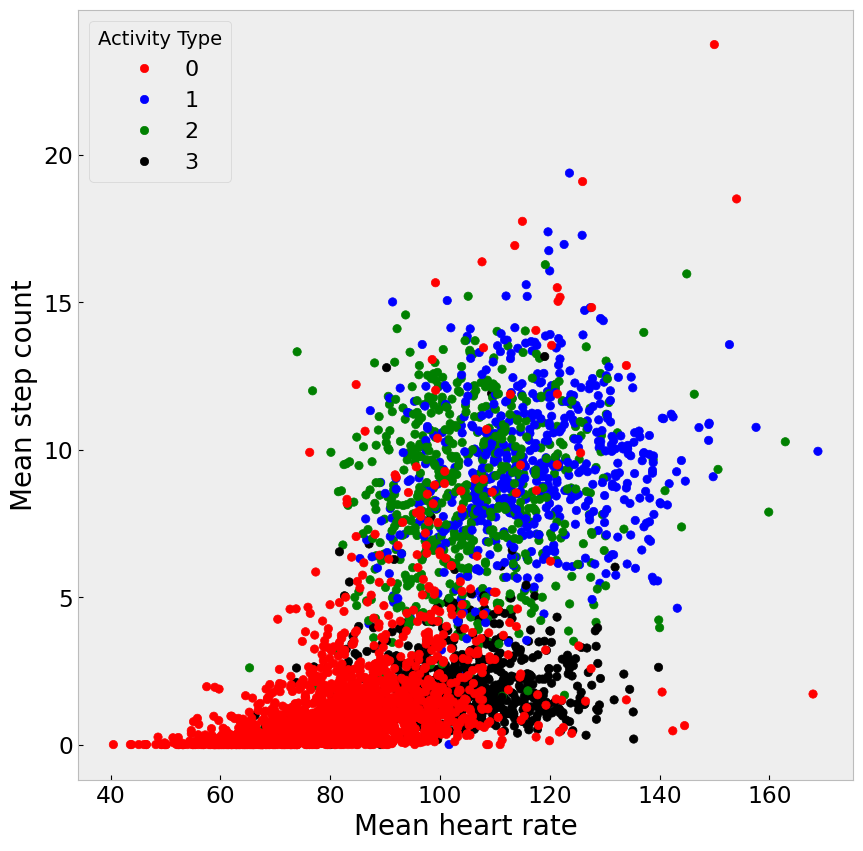

In [6]:
fig, ax = plt.subplots(figsize=[10,10])  #This creates an empty figure of size 10 by 10 inches

#For example we can create a scatter plot of mean hear rate on the x axis and mean step counts on the y axis, 
#and color coded by sedentary
colours = ListedColormap(['r','b','g','k'])
scatter = ax.scatter(clean_dataTable['Average_HR'], clean_dataTable['Average_SC'], c=clean_dataTable['ActivityCategorical'],cmap=colours)
plt.xlabel('Mean heart rate', fontsize=20)
plt.ylabel('Mean step count', fontsize=20)
plt.legend(*scatter.legend_elements(),title="Activity Type",fontsize=16)
ax.yaxis.set_tick_params(labelsize='large')
ax.xaxis.set_tick_params(labelsize='large')
# Note that a label of 0 is sedentary, 1 is aerobic, 2 is interval, 3 is resistance
plt.grid()
plt.show()


# Split the dataset into training and test sets

In [6]:
exerciseData_activityClassifier=clean_dataTable.loc[:,['Minimum_HR','Maximum_HR','Average_HR',
                                                       'Delta_HR','Standard_Dev_SC','Maximum_SC',
                                                       'Average_SC','Sum_SC']]


# This is an important hyperparameter which determines how the training and validation data is split.
random_state=1

# # Split the dataset into training and test sets using sklearn's train_test_split
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(exerciseData_activityClassifier,
                                                                    clean_dataTable.ActivityCategorical, 
                                                                    test_size=0.30,
                                                                    random_state=random_state)

#First to split to train, test and then split train again into validation and train.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val,
                                                                    y_train_val, 
                                                                    test_size=0.20,
                                                                    random_state=random_state)

# Dataset rescaling

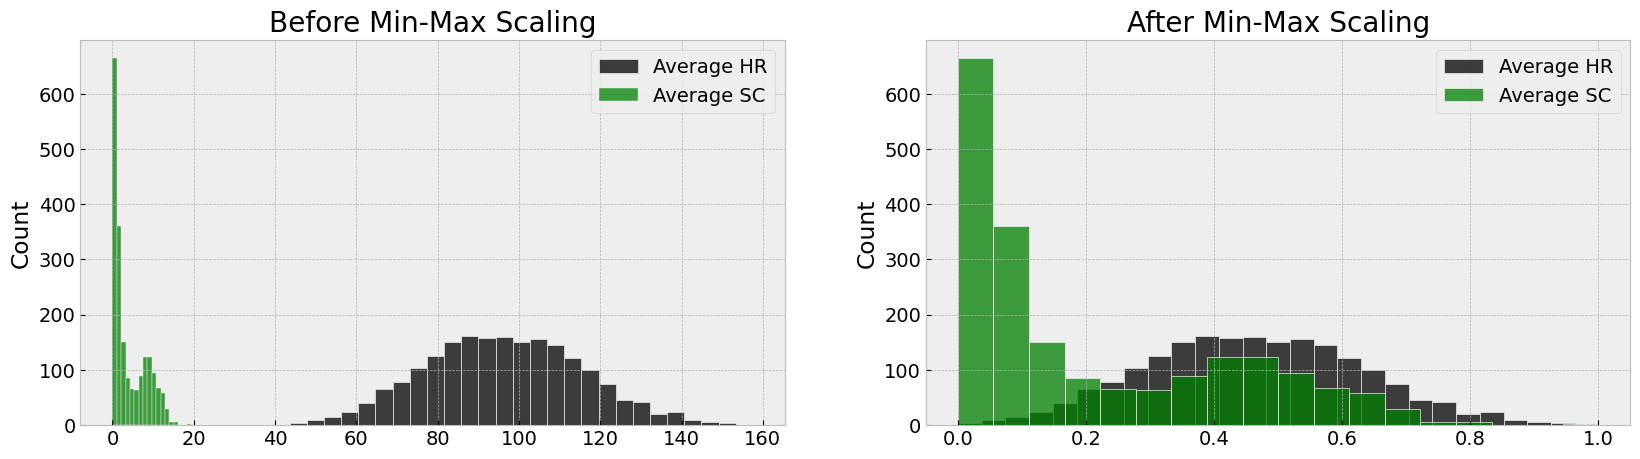

In [7]:
# Define a scaler which standardizes the data scales all 
#the data features in the range [0, 1] or else in the range [-1, 1] 
#if there are negative values in the dataset. 
#This usually improves stability and performance
scaler = preprocessing.MinMaxScaler().fit(X_train) 

#Apply the scaler to the input data
df_scaled_X = scaler.transform(X_train)
df_scaled_X_val = scaler.transform(X_val)
df_scaled_X_test = scaler.transform(X_test)


df_scaled_X_train_val = scaler.transform(X_train_val)


#No need to rescale the output data because they are categorical 
y_train=y_train.to_numpy()
y_val=y_val.to_numpy()
y_test=y_test.to_numpy()

y_train_val=y_train_val.to_numpy()


#Plot the scaled features
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))

df_scaled = pd.DataFrame(df_scaled_X, columns =['Minimum_HR','Maximum_HR','Average_HR',
                                                       'Delta_HR','Standard_Dev_SC','Maximum_SC',
                                                       'Average_SC','Sum_SC'])
sns.histplot(X_train['Average_HR'], ax = ax1, color ='black')
sns.histplot(X_train['Average_SC'],ax = ax1, color ='g')
ax1.set_title('Before Min-Max Scaling')
ax1.set_xlabel('', fontsize=20)
ax1.legend(["Average HR","Average SC"])

sns.histplot(df_scaled['Average_HR'], ax = ax2, color ='black')
sns.histplot(df_scaled['Average_SC'],ax = ax2, color ='g')
ax2.set_title('After Min-Max Scaling')
ax2.set_xlabel('', fontsize=20)
ax2.legend(["Average HR","Average SC"])

# Hyperparameters  and Model Identification

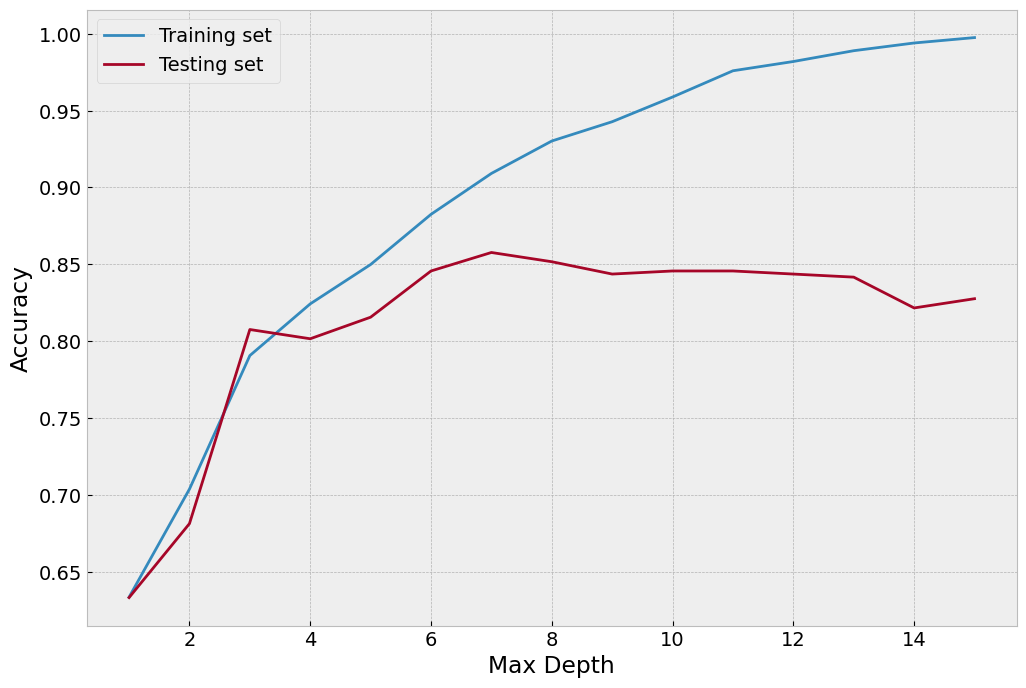

In [13]:
# Create empty variables to store the decision tree accuracy results
training_accuracy = []
testing_accuracy = []

# Define the range of decision tree as 1 - 15
max_dep = range(1,16)

# # Use a for loop to try each of the maximum depth decision trees, and store the scores in the appropriate lists
for md in max_dep:
    tree = DecisionTreeClassifier(max_depth=md,random_state=0)
    tree.fit(df_scaled_X,y_train)
    training_accuracy.append(tree.score(df_scaled_X, y_train))
    testing_accuracy.append(tree.score(df_scaled_X_val, y_val))

# Plot the tree depths against training and validation set accuracies
plt.figure()
plt.plot(max_dep,training_accuracy, label='Training set')
plt.plot(max_dep,testing_accuracy, label='Testing set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

# Decision Tree Classifier

In [21]:
# By looking at the above accuracy plot, the best validation accuracy is when max_depth is 3. 
# Above this value, the model isn't as accurate on the validation set.
# Let's re-train the tree with max_depth = 3

max_depth = 8

treeModel = DecisionTreeClassifier(max_depth=max_depth,random_state=0)
treeModel.fit(df_scaled_X_train_val,y_train_val)
training_accuracy = treeModel.score(df_scaled_X_train_val, y_train_val)
testing_accuracy = treeModel.score(df_scaled_X_test, y_test)
print('The training accuracy is: ', training_accuracy)
print('The testing accuracy is: ', testing_accuracy)



The training accuracy is:  0.923323966278603
The testing accuracy is:  0.8604868913857678


# Feature ranking

In [22]:
importances=treeModel.feature_importances_
columns =['Minimum_HR','Maximum_HR','Average_HR','Delta_HR','Standard_Dev_SC','Maximum_SC',
                                                       'Average_SC','Sum_SC']
for i,v in enumerate(importances):
    print('%s Score: %.5f' %  (columns[i], v))
      

Minimum_HR Score: 0.01336
Maximum_HR Score: 0.01417
Average_HR Score: 0.21735
Delta_HR Score: 0.01363
Standard_Dev_SC Score: 0.03432
Maximum_SC Score: 0.03833
Average_SC Score: 0.46839
Sum_SC Score: 0.20045


# Confusion Matrix

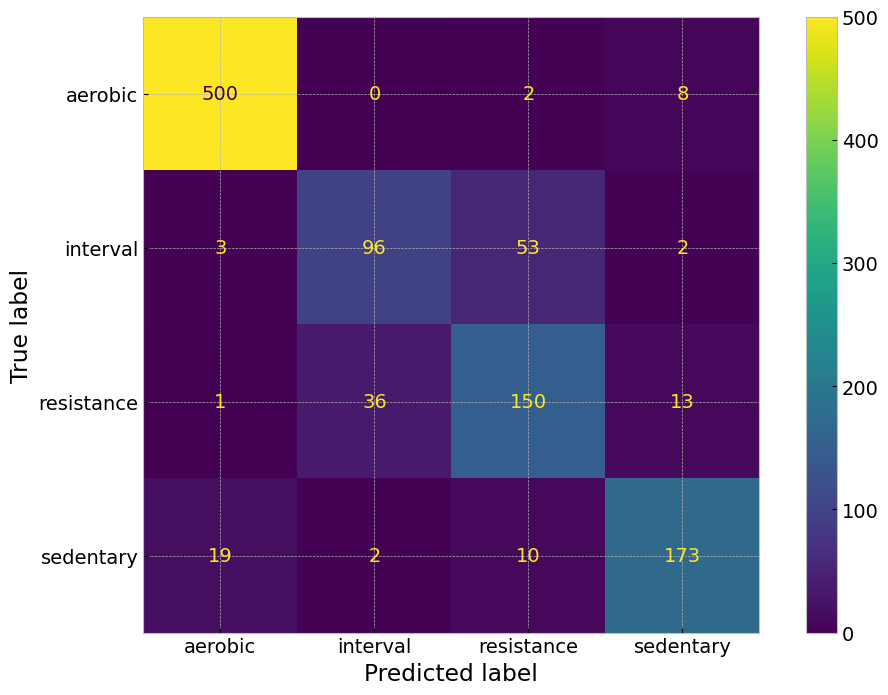

In [23]:
predictions = treeModel.predict(df_scaled_X_test)
cm = confusion_matrix(y_test, predictions, labels=treeModel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['aerobic','interval','resistance','sedentary'])

disp.plot()
plt.show()



# Cross Validation

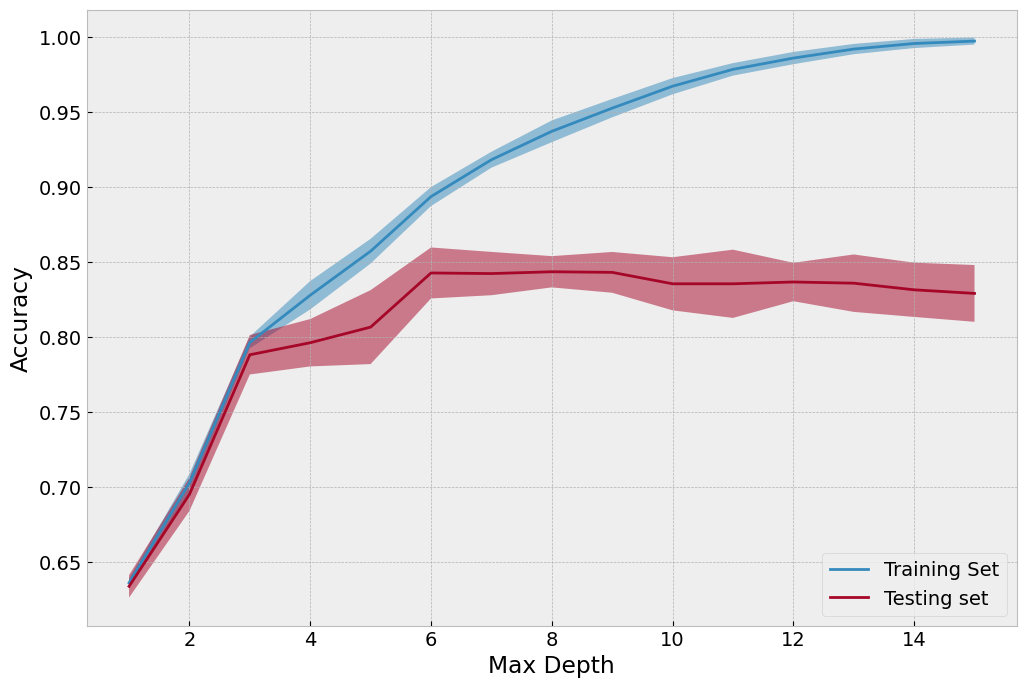

In [8]:
# Create empty variables to store the decision tree accuracy results
training_accuracy = []
testing_accuracy = []


# Define the range of decision tree depths you want to train
max_dep = range(1,16)

# Use a for loop to test each of the 15 maximum depth settings in the decision tree.
# *NOTE* This time we use the `cross_validate` function to get 5 results on the training and validation fold for each maximum depth!
for md in max_dep:
    treeModel = DecisionTreeClassifier(max_depth=md,random_state=0)
    
    results = cross_validate(treeModel,df_scaled_X_train_val, y_train_val, cv=5, scoring={'accuracy': make_scorer(accuracy_score)},
                             return_train_score=True)
    training_accuracy.append(results['train_accuracy'])
    testing_accuracy.append(results['test_accuracy'])

    
# Now the train_accuracy and validation_accuracy lists contain 15 different lists, each with 5 accuracy values for each fold.
# Let's visualize all this information in the same line plot, by plotting the mean accuracies for each maximum depth +/- the standard deviations
training_acc_mean = np.mean(training_accuracy, axis=1)
training_acc_std = np.std(training_accuracy, axis=1)
val_acc_mean = np.mean(testing_accuracy, axis=1)
val_acc_std = np.std(testing_accuracy, axis=1)

plt.figure()
plt.plot(max_dep, training_acc_mean, label='Training Set')
plt.fill_between(max_dep, training_acc_mean-training_acc_std, training_acc_mean+training_acc_std, alpha=0.5)
plt.plot(max_dep, val_acc_mean, label='Testing set')
plt.fill_between(max_dep, val_acc_mean-val_acc_std, val_acc_mean+val_acc_std, alpha=0.5)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend(loc='lower right')
plt.show()